In [130]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
import cv2
from skimage import io
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

# Head counter

## Labeled images

In [132]:
annotations = pd.read_csv('images/annotations.csv', header=None, names=['class', 'x', 'y', 'image', 'w', 'h'])
images_paths = list(Path('images').glob('*.jpg'))

width, height = annotations[['w', 'h']].mean().astype(int)

# Load images and annotations
images_info = [
    {
        "image": io.imread(path).astype(np.uint8),
        "annotation": annotations[annotations['image'] == path.name][['x', 'y']],
    } 
    for path in images_paths]

# Add gray images
for info in images_info:
    info['gray_image'] = cv2.cvtColor(info['image'], cv2.COLOR_BGR2GRAY)


# Get reference image
reference_image_info = images_info[0]

# Get the rest of the images
images_info = images_info[1:]

In [133]:
images_info[0]["annotation"]

,x,y
0,361,588
1,1366,607
2,1350,617
3,1319,456
4,1309,458
5,1469,464
6,1546,466
7,1561,452
8,1613,443


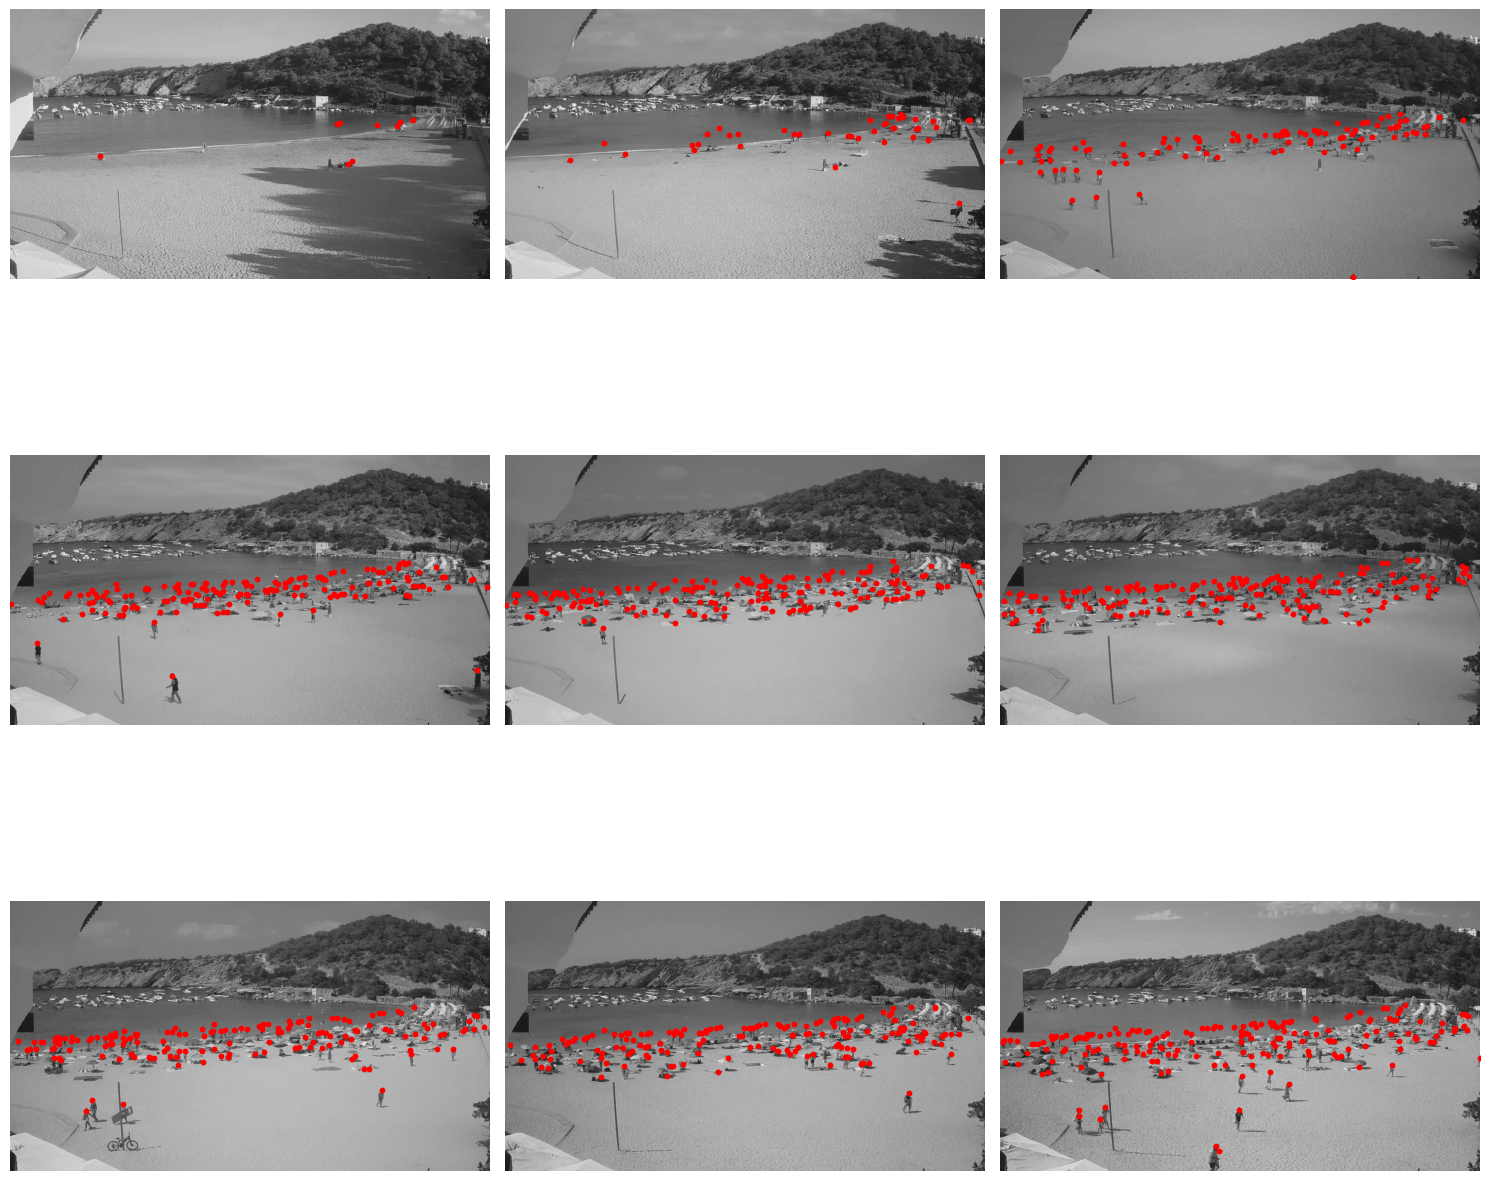

In [134]:
import matplotlib.pyplot as plt

n_cols = 3
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

axes = axes.flatten()

for i, info in enumerate(images_info):
    image = info['gray_image']
    annotation = info['annotation']
    axes[i].imshow(image, cmap='gray')
    axes[i].scatter(annotation['x'], annotation['y'], color='red', marker='o', s=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


---

In [135]:
images = [io.imread(path) for path in Path('images').glob('*.jpg')]

In [136]:
gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]

reference_image = gray_images[0]
gray_images = gray_images[1:]


In [137]:
# show images in notebook

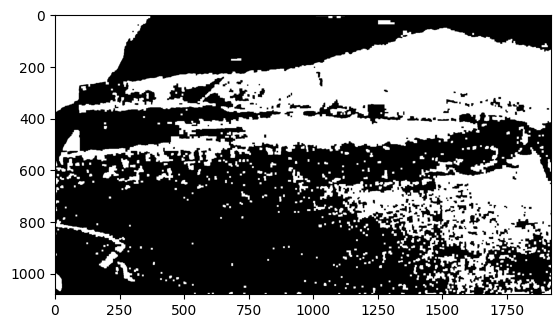

In [138]:
# Calculate the fixed part of the background
from lib.morphological import opening, closing


background_pixels = np.ones_like(reference_image)
for image in gray_images:
    diff = cv2.absdiff(reference_image, image)

    background_pixels &= diff < 65


background_pixels = opening(image=background_pixels, kernel=np.ones((7, 7)))
background_pixels = closing(image=background_pixels, kernel=np.ones((5, 5)))

plt.imshow(background_pixels, cmap='gray')

pass;


In [139]:
images_whitout_background = [image * (1-background_pixels) for image in gray_images]
reference_image = reference_image * (1-background_pixels)

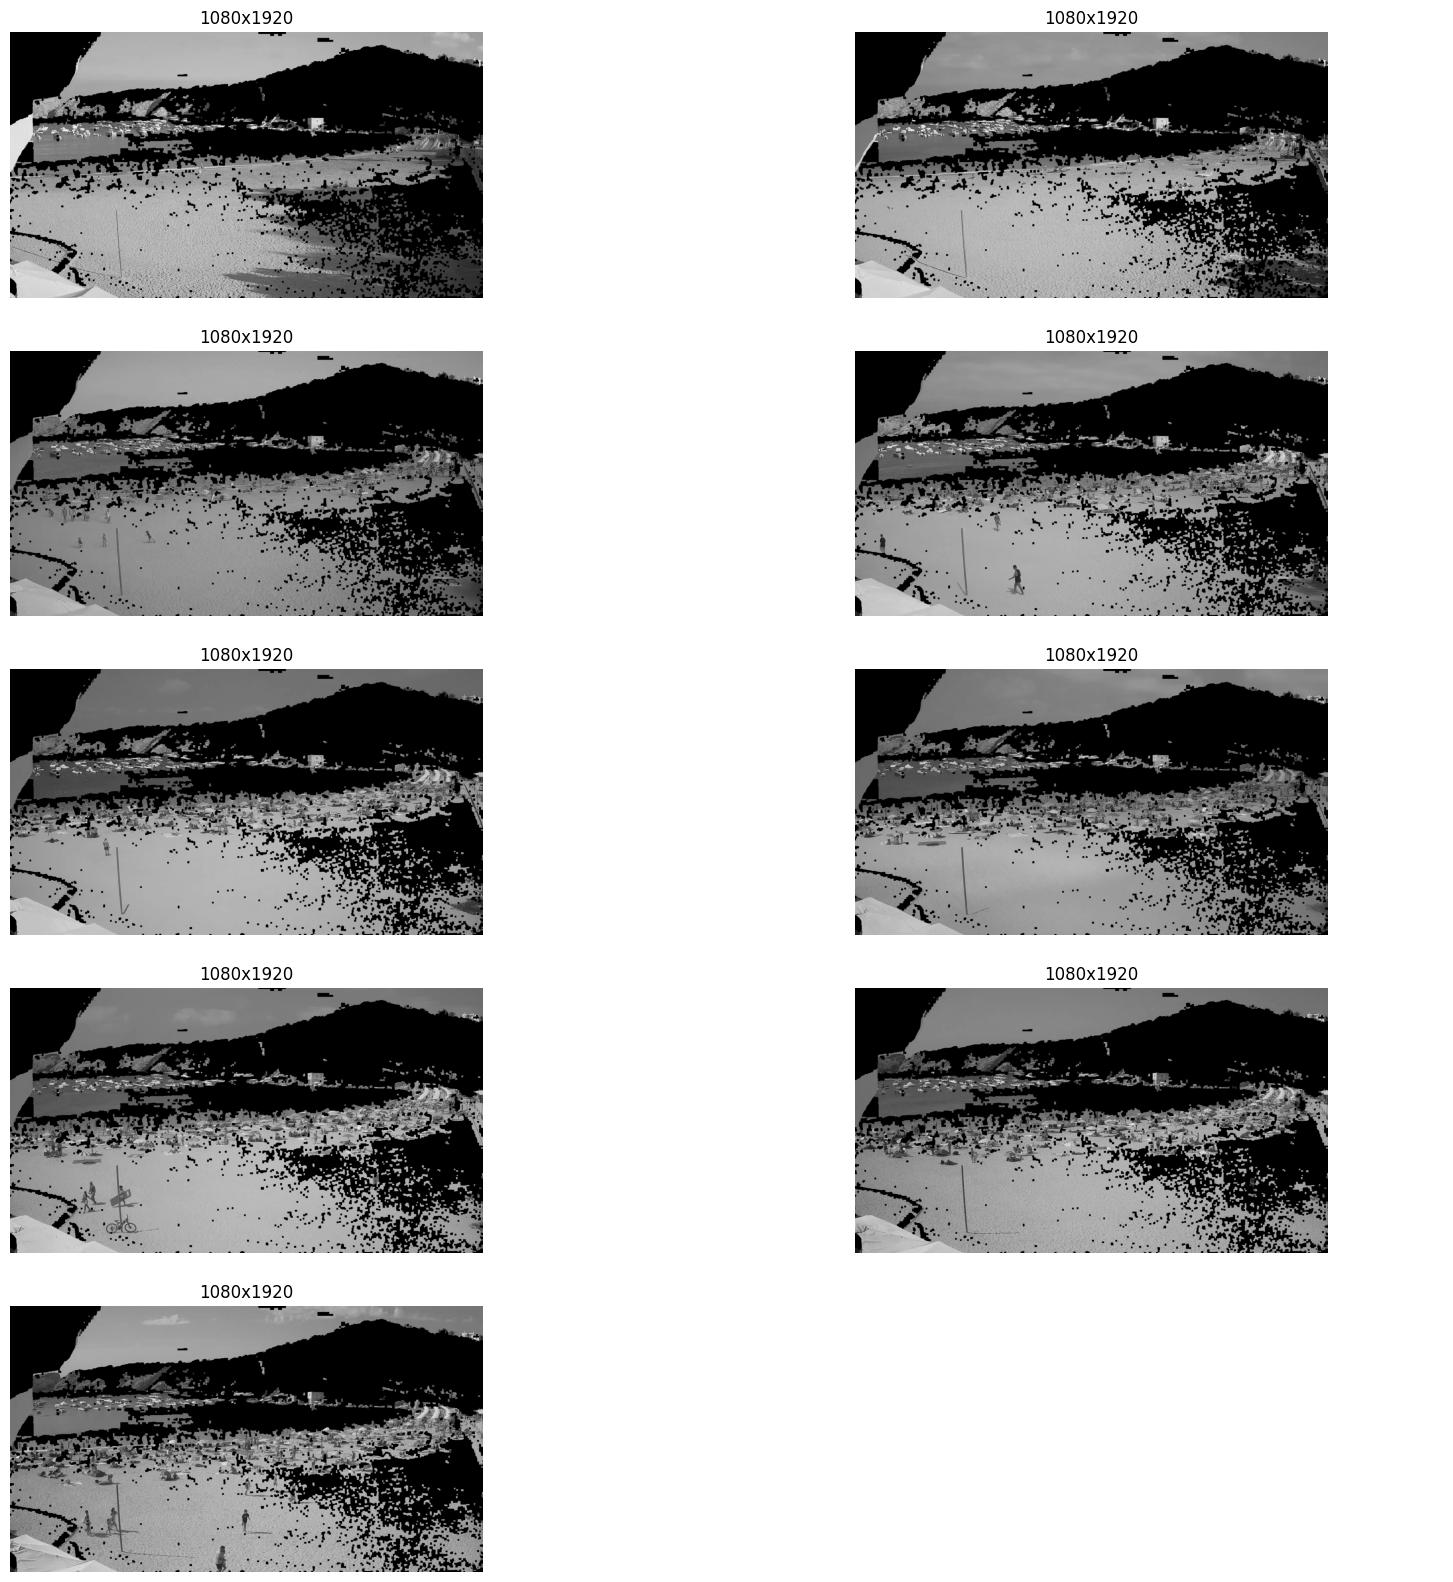

In [140]:
import math
n_cols = 2
fig, axes = plt.subplots(
    math.ceil(len(images_whitout_background)/n_cols), n_cols, figsize=(20, 20))

axes = axes.flatten()


for ax in axes:
    ax.axis('off')

for image, ax in zip(images_whitout_background, axes):
    ax.imshow(image, cmap='gray')
    ax.set_title(f'{image.shape[0]}x{image.shape[1]}')
    

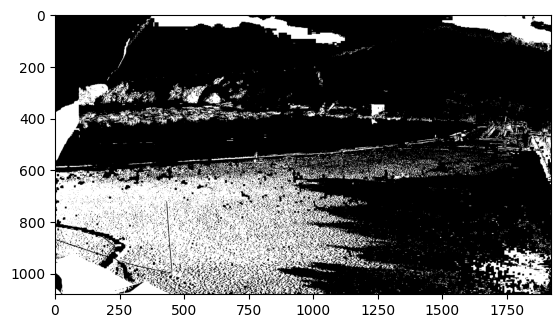

In [141]:
diff = cv2.absdiff(reference_image, images_whitout_background[0])

ret, thresh = cv2.threshold(diff, 40, 255, cv2.THRESH_BINARY)

plt.imshow(thresh, cmap='gray')

## Evaluation

In [147]:
from lib.evaluate import person_level_evaluation

results = images_info[0]["annotation"][0:2].copy()

results.loc[-1] = [750, 800]

# results.x[0] = results.x[0] + 15
res = person_level_evaluation(results=results, labels=images_info[0]["annotation"], width=width, height=height, max_distance=15)

In [149]:
print(f"total: {len(images_info[0]['annotation'])}")
print(res)

total: 9
{'accuracy': 0.2, 'recall': 0.2222222222222222, 'precision': 0.6666666666666666, 'f1': 0.3333333333333333}
